# NBA Race to Contend : 40 before 20

*Excerpt from http://www.espn.com/nba/powerrankings?year=2008&week=18*

> The latest pearl of Zen wisdom from Phil Jackson: "40 before 20." Translation: You must win 40 games before you lose 20 to be seen as an elite team

## 1: Gathering Information and prototyping

First we should gather all the information about the teams for easier reference, we can take advange of the ``nba_api`` library and the static information it will provide. Let's look at what we can get

In [1]:
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
# What does this data look like?
nba_teams[2]

{'id': 1610612739,
 'full_name': 'Cleveland Cavaliers',
 'abbreviation': 'CLE',
 'nickname': 'Cavaliers',
 'city': 'Cleveland',
 'state': 'Ohio',
 'year_founded': 1970}

With this we can query the statistical endpoints from the nba website and the ``nba_api`` library.

We're interested in the magical win record score so we need to trace how a team progresses through the season. More importantly, **we don't want to just look at the end of the season to see a win record**, we're more interested in seeing if a team hit's 40 wins before 40 losses.

Let's extract the game record for a team.

In [2]:
from nba_api.stats.endpoints import teamgamelog

In [3]:
gsw = [team for team in nba_teams if team['abbreviation'] == 'GSW'][0]
gsw

{'id': 1610612744,
 'full_name': 'Golden State Warriors',
 'abbreviation': 'GSW',
 'nickname': 'Warriors',
 'city': 'Golden State',
 'state': 'California',
 'year_founded': 1946}

In [4]:
gameLog = teamgamelog.TeamGameLog(gsw['id']).get_dict()

The gameLog variable has quite a bit of information in it so let's inspect it and see what is accessible.

In [5]:
singleGame = gameLog['resultSets'][0]['rowSet'][0]
singleGame

[1610612744,
 '0021801000',
 'MAR 10, 2019',
 'GSW vs. PHX',
 'L',
 45,
 21,
 0.682,
 240,
 42,
 95,
 0.442,
 10,
 43,
 0.233,
 17,
 22,
 0.773,
 15,
 34,
 49,
 34,
 10,
 6,
 17,
 24,
 111]

Well those are a bunch of weird values, thankfully they package the headers for us so let's combine the data for us to get a better sense of what the information is.

In [6]:
matchedValues = dict(zip(gameLog['resultSets'][0]['headers'],singleGame))
matchedValues

{'Team_ID': 1610612744,
 'Game_ID': '0021801000',
 'GAME_DATE': 'MAR 10, 2019',
 'MATCHUP': 'GSW vs. PHX',
 'WL': 'L',
 'W': 45,
 'L': 21,
 'W_PCT': 0.682,
 'MIN': 240,
 'FGM': 42,
 'FGA': 95,
 'FG_PCT': 0.442,
 'FG3M': 10,
 'FG3A': 43,
 'FG3_PCT': 0.233,
 'FTM': 17,
 'FTA': 22,
 'FT_PCT': 0.773,
 'OREB': 15,
 'DREB': 34,
 'REB': 49,
 'AST': 34,
 'STL': 10,
 'BLK': 6,
 'TOV': 17,
 'PF': 24,
 'PTS': 111}

NBA actually provides us with quite a bit of information. But we're primarily interested in the `WL` value. Unfortunetly we're not given a dictionary structure so we can't refer to it in a "nice" way, we'll just have to remember that the 4th record.

So `gameLog['resultSets'][0]['rowSet'][i][4]` will give us the `WL` record for game `i`.

Let's gather all the games available and see what we get.

In [7]:
for game in gameLog['resultSets'][0]['rowSet']:
    print(game[4])

L
W
L
W
L
L
W
L
W
L
W
W
W
W
W
L
W
W
W
W
W
W
W
W
W
W
W
L
W
W
L
L
W
W
L
W
W
L
W
W
W
W
L
L
W
W
W
L
L
L
L
W
L
W
L
W
W
W
W
W
W
W
W
L
W
W


This structure of code is quite common so we can take advantage of python ***List Comprehensions***. This will automatically take our loop and store the values in the variable.

In [8]:
winLossRecord = [game[4] for game in gameLog['resultSets'][0]['rowSet']]

In [9]:
# Let's look at 10 records
winLossRecord[:10]

['L', 'W', 'L', 'W', 'L', 'L', 'W', 'L', 'W', 'L']

An issue with this format is that games are either Win or Loss, but we're given a character as that representation. A `True` or `False` condition of whether or not the team had won makes more sense. Let's convert those characters to a more friendly `boolean` type.

All we need to do is ask if the character is a `'W'` or not.

In [10]:
winLossRecord = [game[4] == 'W' for game in gameLog['resultSets'][0]['rowSet']]
winLossRecord.reverse() #The api returns the most recent game first. We want to start with the oldest game (game 1)
winLossRecord[:10]

[True, True, False, True, True, True, True, True, True, True]

This will let us do more interesting computations.

Going back to what we're interested in, we'd like to compute the win record as a rolling value. This will be good for our visualizations in a bit, but to give an example of what transformation we want to see consider the following:

`[False, True, False, True, False, False, True, False, True, False]` to become

`[0, 1, 1, 2, 2, 2, 3, 3, 4, 4]`

This transformation is a bit more nuanced but we can take advantage of some really cool ["code-golf"](https://codegolf.stackexchange.com/) features within python, but be warned that [Here be Dragons](https://www.wikiwand.com/en/Here_be_dragons) but we will work it out.

In [11]:
rollingCount = [winLossRecord[:x+1].count(True) for x in range(len(winLossRecord))]
rollingCount[:10]

[1, 2, 2, 3, 4, 5, 6, 7, 8, 9]

Quite the one liner. Now this isn't the most efficient code but it is the most succint. Let's look into it a little bit more to figure out what is going on.

`range(len(winLossRecord))` gives us an index for every value in the `winLossRecord` list and stores that value in `x`.

Once we have that, we can go back into `winLossRecord` and slice, or give us a subsection of the list, from the first value to the `x+1` value. From there, we ask to count how many `True` values exist.

This is what is considered a "cute" solution, it's not the most efficient, but it's succint. [Some soon to be implemented features in python can help make the solution efficient and "cute'](https://www.python.org/dev/peps/pep-0572/).

Now we can see a win record as we progress through the season. Let's see how that looks plotted.

In [17]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline

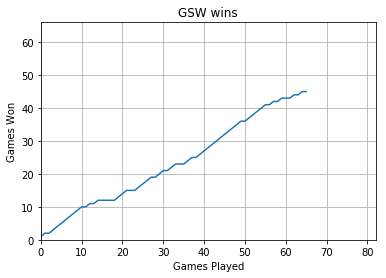

In [16]:
gameRange = np.arange(len(rollingCount))
plt.plot(gameRange, rollingCount)

# Plot labels and formatting
plt.title(gsw['abbreviation']+" wins")
plt.xlabel('Games Played')
plt.ylabel('Games Won')
plt.xlim([0,82])
plt.ylim([0,len(rollingCount)])
plt.grid(True)

Now we've got a pretty good prototype of a running win rate graph. With grids enabled we can get a good sense for progress, but let's make it more obvious.

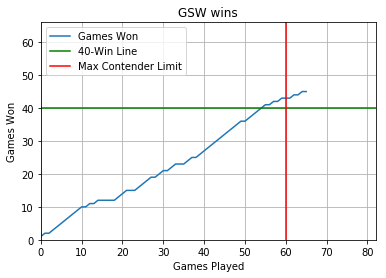

In [26]:
gameRange = np.arange(len(rollingCount))
plt.plot(gameRange, rollingCount, label="Games Won")

plt.axhline(y=40, color='g', label="40-Win Line")
plt.axvline(x=60, color='r', label="Max Contender Limit")

# Plot labels and formatting
plt.title(gsw['abbreviation']+" wins")
plt.xlabel('Games Played')
plt.ylabel('Games Won')
plt.xlim([0,82])
plt.ylim([0,len(rollingCount)])
plt.legend(loc="upper left")
plt.grid(True)

That looks pretty good. Let's generalize this for any given team.